# System Identification in Frequency Domain

In [1]:
%matplotlib inline
import os
import pywt
import itertools
from itertools import zip_longest
import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
import bamboolib # gui for pandas df
from scipy.fftpack import fft
from scipy.signal import welch
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.api import OLS
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter

from scipy.io import loadmat
import seaborn as sns
from math import floor,ceil
import tkinter as tk
import decimal
from random import shuffle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import concurrent.futures # for parallel processing
import glob

/home/mtt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### GPU Availability

In [2]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print('GPU not available')

GeForce RTX 2080 Ti


# Loading The Dataset (Trial by Trial)

In [3]:
# Get the participant data from Dataset directory
global t0, fs, dt, num_eeg_ch, num_emg_ch, num_force_ch, num_ch, num_conds
t0 = 0
fs = 1200
dt = 1.0/fs
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_ch = num_eeg_ch + num_emg_ch + num_force_ch
num_conds = 18

# Get a list of files to process
data_files = list(map(loadmat, glob.glob("Dataset/*.mat")))
num_participants = len(data_files)

columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
         'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
         'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
         'EMG-2','EMG-3','EMG-4','Force-x', 
         'Force-y','Force-z']

glob.glob("Dataset/*.mat")

['Dataset/WC1200Hz.mat',
 'Dataset/P11200Hz.mat',
 'Dataset/JT1200Hz.mat',
 'Dataset/BT1200Hz.mat',
 'Dataset/YA1200Hz.mat',
 'Dataset/YZ1200Hz.mat',
 'Dataset/HCH1200Hz.mat',
 'Dataset/CC1200Hz.mat',
 'Dataset/ED1200Hz.mat',
 'Dataset/YK1200Hz.mat',
 'Dataset/KH1200Hz.mat']

In [4]:
def extract_data(file):
    data_splitBy_trials = [] # list of data frames, each df corresponding to a trial

    for cond in tqdm_notebook(range(num_conds), ascii=True):
        num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
        # if a trial has long enough samples >= (400 samples)
        if file['EEGSeg_Ch'][0,0][0,cond].shape[1] >= 400:
            for trial in range(num_trials): 
                data = pd.DataFrame(columns=columns)
                for ch in range(num_eeg_ch):
                    data.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_emg_ch):
                    data.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_force_ch):
                    data.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond][trial,:]

                # mean subtraction in each trial from the eeg and emg columns for removing dc drift
                data.iloc[:,:18] -= data.iloc[:,:18].mean()
                # convert volts to microvolts for EEG and EMG channels
                data.iloc[:,:18] *= 1e6
                # convert volts to milivolts for force channels
                data.iloc[:,18:] *= 1e3  
                data_splitBy_trials.append(data)
                
    train_data, test_data = train_test_split(data_splitBy_trials)
    return train_data, test_data


def train_test_split(data, train_ratio=0.5):
    #shuffle(data) # shuffle list, in-place operator
    num_train = int(train_ratio*len(data))
    train_data, test_data = data[:num_train], data[num_train:]
    return train_data, test_data


train_data = [] # train data is a list (all participants each trial) of dataframes
test_data = [] # test data is a list (each participant) of list (each trial) of dataframes 

print('Reading and processing in parallel.')

# Create a pool of processes. By default, one is created for each CPU in your machine.
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Process the list of files, but split the work across the process pool to use all CPUs.
    # executor.map() function takes in the helper function to call and the list of data to process with it.
    # executor.map() function returns results in  the same order as the list of data given to the process.
    for train, test in tqdm_notebook(executor.map(extract_data, data_files), total=len(data_files)):
        train_data.extend(train)
        test_data.append(test)
        
total_trials = len(train_data)
for test in test_data:
    total_trials += len(test)
print('Total number of trials of all the conditions in the file: %i' %total_trials) 
train_data[0].head(10) # first 10 samples of the first trial

Reading and processing in parallel.














Total number of trials of all the conditions in the file: 17648


,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,3.687146,-35.045728,6.736703,-21.818788,-6.802053,9.982662,16.466473,-8.706051,-14.135378,-16.280629,...,-5.091214,-8.117129,-13.509302,-81.175266,-10170.117197,379.767147,-9938.067833,0.160920,-0.088876,262.796611
1,3.296706,-35.941440,6.005416,-23.318986,-8.382351,9.063103,15.518252,-10.094022,-15.703900,-17.756540,...,-6.993445,-9.620401,-15.025547,-22.061894,-10205.017579,358.617044,-9953.617195,0.170733,-0.089729,263.696700
2,1.931423,-36.955098,4.335833,-24.840572,-10.057575,7.090975,13.444592,-11.567166,-17.266320,-19.197980,...,-8.945217,-11.202073,-16.476992,98.069172,-10195.136247,323.211420,-10030.186812,0.159536,-0.089377,265.052944
3,0.059206,-37.886035,2.234656,-26.180461,-11.549615,4.635877,10.839381,-12.859211,-18.604442,-20.398685,...,-10.606914,-12.599074,-17.634563,260.137694,-10146.463466,277.245063,-9999.490420,0.126334,-0.090375,267.145663
4,-1.831391,-38.553458,0.221460,-27.157279,-12.608631,2.278883,8.309446,-13.731056,-19.526752,-21.179851,...,-11.677825,-13.574842,-18.299681,483.827174,-10230.535818,297.544286,-10006.642977,0.075654,-0.089827,269.759804
5,-3.292171,-38.818380,-1.235936,-27.631988,-13.041876,0.540547,6.399245,-13.999109,-19.890560,-21.411119,...,-11.930361,-13.946865,-18.327453,375.427280,-10256.540207,329.146506,-10024.300853,0.014280,-0.090520,272.848487
6,-3.970247,-38.600591,-1.778893,-27.524072,-12.736047,-0.182707,5.524396,-13.557216,-19.618838,-21.026364,...,-11.235952,-13.608092,-17.644005,149.644652,-10310.717104,333.016267,-10106.644670,-0.051569,-0.090788,276.493877
7,-3.651375,-37.889085,-1.202268,-26.821504,-11.670855,0.332708,5.920754,-12.390004,-18.710193,-20.032727,...,-9.580190,-12.540150,-16.256216,65.641219,-10224.355561,330.585865,-10021.141807,-0.122537,-0.089762,280.077904
8,-2.286830,-36.744995,0.519308,-25.583917,-9.922555,2.109475,7.615144,-10.576458,-17.241033,-18.512246,...,-7.065590,-10.817043,-14.253255,68.754863,-10213.423697,309.997582,-9983.978311,-0.181104,-0.088969,282.107443
9,-0.000219,-35.296303,3.226681,-23.938335,-7.657060,4.965293,10.421174,-8.283084,-15.359556,-16.615608,...,-3.901895,-8.598848,-11.799578,115.477687,-10190.157396,304.413605,-9992.896656,-0.227723,-0.089893,282.507628


## Wavelet Data Compression by Thresholding

In [5]:
'''
Soft thresholding sets the wavelet coefficients with absolute value below the threshold to 0 and
other coefficients towards the origin by the magnitude of threshold.

Hard thresholding just sets the wavelet coefficients with absolute value below the threshold to 0.
'''
def threshold_coeffs(coeffs, threshold=1.0, soft=True): # set threshold 0.2 for emg channels.
    if soft == True:
        return [0 if abs(coef)<threshold else coef-np.sign(coef)*threshold for coef in coeffs]
    else:
        return [0 if abs(coef)<threshold else coef for coef in coeffs]

## Linear Regression Based On Thresholded DWT Coefficients

In [6]:
wl_columns=['cA_EEG-1','cD_EEG-1','cA_EEG-2','cD_EEG-2','cA_EEG-3',
            'cD_EEG-3','cA_EEG-4','cD_EEG-4','cA_EEG-5','cD_EEG-5',
            'cA_EEG-6','cD_EEG-6','cA_EEG-7','cD_EEG-7','cA_EEG-8',
            'cD_EEG-8','cA_EEG-9','cD_EEG-9','cA_EEG-10','cD_EEG-10', 
            'cA_EEG-11','cD_EEG-11','cA_EEG-12','cD_EEG-12', 'cA_EEG-13',
            'cD_EEG-13','cA_EEG-14','cD_EEG-14','cA_EMG-1','cD_EMG-1',
            'cA_EMG-2','cD_EMG-2','cA_EMG-3','cD_EMG-3','cA_EMG-4','cD_EMG-4',
            'cA_Force-x','cD_Force-x', 'cA_Force-y','cD_Force-y', 
            'cA_Force-z','cD_Force-z']

# take the discrete wavelet coefficients of train and test data for each trial
'''
return: wavelet_list(a list of DataFrames (for each trial))
'''
def get_wavelet(data):
    wavelet_coef = pd.DataFrame(columns=wl_columns)
    th = 14*[1] + 4*[0.2] + 3*[1] # soft threshold list for all channels
    wavelet_list = []
    for i in tqdm_notebook(range(len(data)), ascii=True):  # for each trial
        for j in range(num_ch):
            cA, cD = pywt.dwt(data[i].iloc[:,j].values, 'db4')
            # Apply soft-thresholding on DWT coeffs
            wavelet_coef[wl_columns[2*j]] = threshold_coeffs(cA, threshold=th[j], soft=True)
            wavelet_coef[wl_columns[2*j+1]] = threshold_coeffs(cD, threshold=th[j], soft=True)
        wavelet_list.append(wavelet_coef)
        # delete the df wavelet_coef for the next trial
        wavelet_coef = wavelet_coef.drop(wavelet_coef.index[:])
    return wavelet_list

train_wavelet = get_wavelet(train_data)
print('Wavelet transform ready for train data')
test_wavelet = []
for i, participant in enumerate(test_data):
    test_wavelet.append(get_wavelet(participant))
    print('Wavelet transform ready for participant %s' %str(i+1))


Wavelet transform ready for train data



Wavelet transform ready for participant 1



Wavelet transform ready for participant 2



Wavelet transform ready for participant 3



Wavelet transform ready for participant 4



Wavelet transform ready for participant 5



Wavelet transform ready for participant 6



Wavelet transform ready for participant 7



Wavelet transform ready for participant 8



Wavelet transform ready for participant 9



Wavelet transform ready for participant 10



Wavelet transform ready for participant 11


## Model Lag Order Selection

In [7]:
# convert series to supervised learning
def get_lagged_series(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# saves bic scores for all model orders:
def save_bic(Y, X, filename, use_saved=True):
    if use_saved==True: return
    lag_bic_scores = np.zeros((1,20))
    for P in tqdm_notebook(range(20), ascii=True):
        bic_score = 0
        lagged_X = get_lagged_series(X)
        for col in Y:
            model = OLS(Y[col][P:], series_to_supervised(X,P,1)).fit()
            bic_score += model.bic         
        lag_bic_scores[0, P] = bic_score        
    np.save(filename, lag_bic_scores)

train_wavelet_df = pd.concat(train_wavelet)

# use only approximation coeefficients for eeg avoid columns with 0's,
# in order to yield a positive-semidefinite matrix
eeg_ind_wl = list(range(0, 28, 2))
emg_ind_wl = list(range(28, 36, 1))
force_ind_wl = list(range(36, 42, 1))

# from EEG to Force    
filename = 'VARResults/EEGtoForce_lagOrder.npy'
Y = train_wavelet_df.iloc[:,force_ind_wl]
X = train_wavelet_df.iloc[:,eeg_ind_wl]
save_bic(Y, X, filename)
print("Lag order selection completed for from EEG to Force.")

# from Force to EEG 
filename = 'VARResults/ForcetoEEG_lagOrder.npy'
Y = train_wavelet_df.iloc[:,eeg_ind_wl]
X = train_wavelet_df.iloc[:,force_ind_wl]
save_bic(Y, X, filename)
print("Lag order selection completed for from Force to EEG.")
 
# from EEG & EMG to Force 
filename = 'VARResults/EEGEMGtoForce_lagOrder.npy'
Y = train_wavelet_df.iloc[:,force_ind_wl]
X = train_wavelet_df.iloc[:,eeg_ind_wl+emg_ind_wl]
save_bic(Y, X, filename)
print("Lag order selection completed for from EEG & EMG to Force.")

# from Force & EMG to EEG
filename = 'VARResults/ForceEMGtoEEG_lagOrder.npy'
Y = train_wavelet_df.iloc[:,eeg_ind_wl]
X = train_wavelet_df.iloc[:,force_ind_wl+emg_ind_wl]
save_bic(Y, X, filename)
print("Lag order selection completed for from Force & EMG to EEG.")

Lag order selection completed for from EEG to Force.
Lag order selection completed for from Force to EEG.
Lag order selection completed for from EEG & EMG to Force.
Lag order selection completed for from Force & EMG to EEG.


## Model Lag Order Results

In [8]:
eeg_to_force = np.load('VARResults/EEGtoForce_lagOrder.npy')
force_to_eeg = np.load('VARResults/ForcetoEEG_lagOrder.npy')
eegemg_to_force = np.load('VARResults/EEGEMGtoForce_lagOrder.npy')
forceemg_to_eeg = np.load('VARResults/ForceEMGtoEEG_lagOrder.npy')

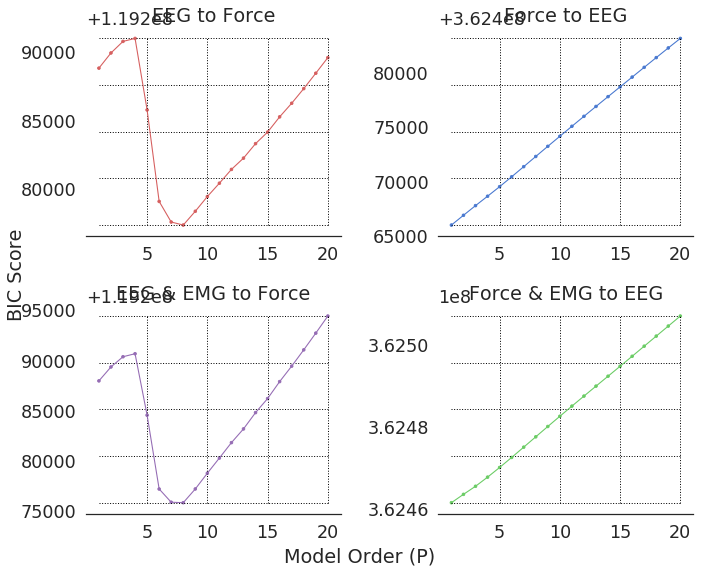

In [9]:
BIC = pd.DataFrame({'eeg_to_force': eeg_to_force[0,:],
                    'force_to_eeg': force_to_eeg[0,:],
                    'eegemg_to_force': eegemg_to_force[0,:],
                    'forceemg_to_eeg': forceemg_to_eeg[0,:]})
model_orders = 1 + np.arange(20)

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.6)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(10,8), sharex=False)
sns.despine(left=True)

sns.pointplot(x=model_orders, y=BIC['eeg_to_force'], color='r', ax=axes[0,0], scale=0.4).set_title('EEG to Force')
sns.pointplot(x=model_orders, y=BIC['force_to_eeg'], color='b', ax=axes[0,1], scale=0.4).set_title('Force to EEG')
sns.pointplot(x=model_orders, y=BIC['eegemg_to_force'], color='m', ax=axes[1,0], scale=0.4).\
                                                          set_title('EEG & EMG to Force')
sns.pointplot(x=model_orders, y=BIC['forceemg_to_eeg'], color='g', ax=axes[1,1], scale=0.4).\
                                                          set_title('Force & EMG to EEG')

for ax in axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# The rest is for some cosmetics of the plots...
# reduce the density of x-axis
for ax in axes.flatten():
    for ind, label in enumerate(ax.get_xticklabels()):
        if (ind+1) % 5 == 0: #every 5th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

# draw vertical lines:
for i in range(4,24,5):
    axes.flatten()[0].vlines(x=i, ymin=BIC['eeg_to_force'].min()-1, ymax=BIC['eeg_to_force'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[1].vlines(x=i, ymin=BIC['force_to_eeg'].min()-1, ymax=BIC['force_to_eeg'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[2].vlines(x=i, ymin=BIC['eegemg_to_force'].min()-0.6, ymax=BIC['eegemg_to_force'].max(), 
                             color='black', alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[3].vlines(x=i, ymin=BIC['forceemg_to_eeg'].min()-0.1, ymax=BIC['forceemg_to_eeg'].max(), 
                             color='black', alpha=1, linewidth=1, linestyles='dotted')

# draw horizontal lines:
for i in np.linspace(int(BIC['eeg_to_force'].min()), int(BIC['eeg_to_force'].max()+1), 5):
    axes.flatten()[0].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.linspace(int(BIC['force_to_eeg'].min()), int(BIC['force_to_eeg'].max()+1), 5):
    axes.flatten()[1].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.linspace(int(BIC['eegemg_to_force'].min()), int(BIC['eegemg_to_force'].max()+1), 5):
    axes.flatten()[2].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.linspace(BIC['forceemg_to_eeg'].min(), BIC['forceemg_to_eeg'].max(), 5):
    axes.flatten()[3].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
    
# display and save
f.text(0.5, 0.0, 'Model Order (P)', ha='center')
f.text(0.01, 0.5, 'BIC Score', va='center', rotation='vertical')
plt.savefig("VARResults/lagOrders.pdf", bbox_inches="tight")
plt.tight_layout()

## Model Training and One Step Ahead Prediction

In [10]:
P_force = 6 # optimal lag order based on BIC plots - if the generated output is Force 
            # data from (t, t-1, .., t-6)
P_eeg = 0   # optimal lag order based on BIC plots - if the generated output is EEG
            # data from only (t)

use_saved = True 

'''
returns: all_forecasts (list(each participant) of lists(each trial) of dataframes)
'''
def fit_model(trainX, trainY, testX, cols, lag_order):
    all_forecasts = []
    models = dict()
    for col in trainY:
        models[col] = OLS(trainY[col][lag_order:], get_lagged_series(trainX,lag_order,1)).fit()    
    
    for i, participant in enumerate(tqdm_notebook(testX, ascii=True)):
        participant_forecast = []
        trial_forecast = pd.DataFrame(columns=trainY.columns)
        for trial in participant:
            for col in trainY.columns:
                trial_forecast[col] = models[col].predict(get_lagged_series(trial.iloc[:,cols], lag_order,1))
            participant_forecast.append(trial_forecast)             
        all_forecasts.append(participant_forecast)
    
    return all_forecasts


if use_saved == False:
    # from EEG to Force prediction
    lag_order = P_force
    trainX = train_wavelet_df.iloc[:,eeg_ind_wl]
    trainY = train_wavelet_df.iloc[:,force_ind_wl]
    cols = eeg_ind_wl
    predicted_eeg_to_force = fit_model(trainX, trainY, test_wavelet, cols, lag_order)
    np.save('VARResults/predicted_eeg_to_force.npy', predicted_eeg_to_force)
    del predicted_eeg_to_force

    # from Force to EEG prediction
    lag_order = P_eeg
    trainX = train_wavelet_df.iloc[:,force_ind_wl]
    trainY = train_wavelet_df.iloc[:,eeg_ind_wl]
    cols = force_ind_wl
    predicted_force_to_eeg = fit_model(trainX, trainY, test_wavelet, cols, lag_order)
    np.save('VARResults/predicted_force_to_eeg.npy', predicted_force_to_eeg)
    del predicted_force_to_eeg
    
    # from EEG & EMG to Force prediction
    lag_order = P_force
    trainX = train_wavelet_df.iloc[:,eeg_ind_wl+emg_ind_wl]
    trainY = train_wavelet_df.iloc[:,force_ind_wl]
    cols = eeg_ind_wl + emg_ind_wl
    predicted_eegemg_to_force = fit_model(trainX, trainY, test_wavelet, cols, lag_order)
    np.save('VARResults/predicted_eegemg_to_force.npy', predicted_eegemg_to_force)
    del predicted_eegemg_to_force

    # from Force & EMG to EEG prediction
    lag_order = P_eeg
    trainX = train_wavelet_df.iloc[:,force_ind_wl+emg_ind_wl]
    trainY = train_wavelet_df.iloc[:,eeg_ind_wl]
    cols = force_ind_wl + emg_ind_wl
    predicted_forceemg_to_eeg = fit_model(trainX, trainY, test_wavelet, cols, lag_order)
    np.save('VARResults/predicted_forceemg_to_eeg.npy', predicted_forceemg_to_eeg)
    del predicted_forceemg_to_eeg

In [11]:
if use_saved == True:
    forecasted_eeg_to_force = np.load('VARResults/predicted_eeg_to_force.npy', allow_pickle=True)
    forecasted_force_to_eeg = np.load('VARResults/predicted_force_to_eeg.npy', allow_pickle=True)
    forecasted_eegemg_to_force = np.load('VARResults/predicted_eegemg_to_force.npy', allow_pickle=True)
    forecasted_forceemg_to_eeg = np.load('VARResults/predicted_forceemg_to_eeg.npy', allow_pickle=True)
    
participant = 0
trial_id = 0
forecasted_eeg_to_force[participant][trial_id].head(10)

,cA_Force-x,cD_Force-x,cA_Force-y,cD_Force-y,cA_Force-z,cD_Force-z
6,-2.208599,-0.002928,-0.363456,0.000490,-3.635283,-0.001176
7,-2.228553,0.012594,-0.487969,0.000175,-4.151035,-0.001990
8,-2.378747,0.003172,-0.878996,0.000019,-4.925389,0.000145
9,-2.445811,-0.001818,-1.028675,-0.000034,-5.312820,0.000671
10,-2.488529,-0.001746,-1.044327,-0.000112,-5.159103,0.000519
11,-2.600226,-0.001272,-1.055532,-0.000145,-4.587354,0.000323
12,-2.826617,-0.000293,-1.108391,-0.000118,-3.831681,0.000075
13,-3.182440,0.001101,-1.244076,-0.000042,-3.185438,-0.000201
14,-3.643309,0.002588,-1.478807,0.000055,-2.878947,-0.000447
15,-4.152754,0.003717,-1.795019,0.000135,-2.987047,-0.000593


In [12]:
# Add to the forecasted dataframes detail coefficients of eeg 
# and then apply inverse discrete wavelet transform to extract the signal.
cols_to_app = ['cD_EEG-1', 'cD_EEG-2', 'cD_EEG-3', 'cD_EEG-4', 'cD_EEG-5', 'cD_EEG-6',
               'cD_EEG-7', 'cD_EEG-8', 'cD_EEG-9', 'cD_EEG-10', 'cD_EEG-11', 'cD_EEG-12',
               'cD_EEG-13', 'cD_EEG-14']

# add the detail coefficients of eeg the col after the app coefficients for each trial
for i in range(num_eeg_ch):
    [trial.insert(2*i+1, cols_to_app[i], 0) for participant in forecasted_force_to_eeg for trial in participant 
                                            if cols_to_app[i] not in trial] 
    [trial.insert(2*i+1, cols_to_app[i], 0) for participant in forecasted_forceemg_to_eeg for trial in participant
                                            if cols_to_app[i] not in trial]
        
# list of dataframes, each as the complete forecasted dwt coefficients for a given modality
f_list = [forecasted_force_to_eeg, forecasted_eeg_to_force,
          forecasted_forceemg_to_eeg, forecasted_eegemg_to_force]

forecasted_force_to_eeg[participant][trial_id].head(5)

,cA_EEG-1,cD_EEG-1,cA_EEG-2,cD_EEG-2,cA_EEG-3,cD_EEG-3,cA_EEG-4,cD_EEG-4,cA_EEG-5,cD_EEG-5,...,cA_EEG-10,cD_EEG-10,cA_EEG-11,cD_EEG-11,cA_EEG-12,cD_EEG-12,cA_EEG-13,cD_EEG-13,cA_EEG-14,cD_EEG-14
0,-0.079914,0,-0.044347,0,-0.050346,0,-0.043890,0,-0.063099,0,...,-0.101079,0,-0.049976,0,-0.072266,0,-0.031384,0,-0.109527,0
1,-0.075557,0,-0.041962,0,-0.048353,0,-0.042758,0,-0.061082,0,...,-0.098240,0,-0.049045,0,-0.070513,0,-0.030902,0,-0.106919,0
2,-0.075520,0,-0.041874,0,-0.048280,0,-0.042676,0,-0.061011,0,...,-0.098136,0,-0.048978,0,-0.070432,0,-0.030852,0,-0.106774,0
3,-0.010895,0,0.047920,0,-0.023618,0,-0.043758,0,-0.065094,0,...,-0.095155,0,-0.044813,0,-0.068009,0,-0.023105,0,-0.101586,0
4,-0.126343,0,0.060242,0,-0.088444,0,0.002265,0,-0.103365,0,...,-0.096514,0,-0.029811,0,-0.091301,0,-0.007804,0,-0.088685,0


In [13]:
eeg_ind = list(range(0,14))
emg_ind = list(range(14,18))
force_ind = list(range(18,21))
c_list = [[columns[i] for i in eeg_ind], 
          [columns[i] for i in force_ind],
          [columns[i] for i in eeg_ind], 
          [columns[i] for i in force_ind]]

# apply inverse discrete wavelet transform to each trial and extract the signals:
def apply_idwt(f, c):
    all_forecasts = []
    for participant in f:
        participant_forecasts = []
        for trial in participant:
            forecast = pd.DataFrame(columns=c)
            for i in range(len(forecast.columns)):
                forecast.iloc[:,i] = pywt.idwt(trial.iloc[:,2*i], 
                                               trial.iloc[:,2*i+1], 'db4')[:-1]
            participant_forecasts.append(forecast)
        all_forecasts.append(participant_forecasts)
    return all_forecasts

# s_list is a list of list of dataframes, each one is the predicted signal for a specific modality
s_list = []
# wl_tuple is the tuple of forecasted dwl coeffs and columns is corresponding modality dataframe's columns
for f,c in zip(f_list, c_list):
    s_list.append(apply_idwt(f,c))

In [14]:
# Select an input modality to plot the predictions:
results_for_force_to_eeg = 0
results_for_eeg_to_force = 1
results_for_forceemg_to_eeg = 2
results_for_eegemg_to_force = -1

def getit():
    global value
    value = v.get()
    
def printit():
    try:
        global value
        if value==0:
            print("From Force to EEG Selected")
            root.destroy()
        elif value==1:
            print("From EEG to Force Selected")
            root.destroy()
        elif value==2:
            print("From Force & EMG to EEG Selected")
            root.destroy()
        elif value==-1:
            print("From EEG & EMG to Force Selected")
            root.destroy()
        del value
    except NameError as e:
        value = 0 
        
root = tk.Tk()

window_height = 100
window_width = 500

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

root.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))
root.title('Modality Selection')
v = tk.IntVar(value=0) # start with the values of one of the buttons
tk.Label(root, text="""Choose an input modality to plot the predictions""",
        justify = tk.LEFT, padx=20).pack()
rb1 = tk.Radiobutton(root, text="From Force to EEG Selected", padx=20, 
                     variable=v, value=0, command=getit).pack(anchor=tk.W)
rb2 = tk.Radiobutton(root, text="From EEG to Force Selected", padx=20, 
                     variable=v, value=1, command=getit).pack(anchor=tk.W)
rb3 = tk.Radiobutton(root, text="From Force & EMG to EEG Selected", 
                     padx=20, variable=v, value=2, command=getit).pack(anchor=tk.W)
rb4 = tk.Radiobutton(root, text="From EEG & EMG to Force Selected", padx=20, 
                     variable=v, value=-1, command=getit).pack(anchor=tk.W)
b = tk.Button(root, text="Submit", command=printit).pack(anchor=tk.W)

root.mainloop()

From EEG to Force Selected


In [15]:
modality = v.get()

# if modality == 0: force to eeg
# if modality == 1: eeg to force 
# if modality == 2: force & emg to eeg
# if modality == 3: eeg & emg to force

modality = 0

f_list[modality][4][98].head(10)

,cA_EEG-1,cD_EEG-1,cA_EEG-2,cD_EEG-2,cA_EEG-3,cD_EEG-3,cA_EEG-4,cD_EEG-4,cA_EEG-5,cD_EEG-5,...,cA_EEG-10,cD_EEG-10,cA_EEG-11,cD_EEG-11,cA_EEG-12,cD_EEG-12,cA_EEG-13,cD_EEG-13,cA_EEG-14,cD_EEG-14
0,0.114010,0,0.058203,0,0.031856,0,-0.003338,0,0.016950,0,...,0.008291,0,-0.020215,0,-0.008132,0,-0.018183,0,-0.016035,0
1,0.123600,0,0.064255,0,0.037699,0,0.001363,0,0.023570,0,...,0.018376,0,-0.015530,0,-0.001133,0,-0.015259,0,-0.005210,0
2,0.123541,0,0.064753,0,0.038145,0,0.001980,0,0.024041,0,...,0.019094,0,-0.014993,0,-0.000538,0,-0.014850,0,-0.004116,0
3,0.118902,0,0.135744,0,0.049519,0,-0.018684,0,0.027062,0,...,0.039635,0,-0.017549,0,0.009678,0,0.001085,0,0.016273,0
4,-0.019435,0,0.324522,0,-0.083007,0,0.139514,0,-0.099662,0,...,0.013051,0,0.040182,0,-0.066255,0,0.043125,0,0.036401,0
5,0.162979,0,-0.121629,0,0.082119,0,-0.049755,0,0.073285,0,...,-0.007511,0,-0.041528,0,0.016970,0,-0.053678,0,-0.045627,0
6,0.126590,0,-0.046722,0,-0.014398,0,-0.099097,0,-0.032065,0,...,-0.090064,0,-0.096578,0,-0.079820,0,-0.078683,0,-0.165958,0
7,0.345019,0,-0.252587,0,-0.248497,0,-0.444965,0,-0.267456,0,...,-0.416122,0,-0.391652,0,-0.388777,0,-0.313564,0,-0.751811,0
8,0.409804,0,-0.319317,0,-0.254913,0,-0.506567,0,-0.272072,0,...,-0.448651,0,-0.434669,0,-0.412662,0,-0.352344,0,-0.826279,0
9,0.253231,0,-0.078460,0,-0.207834,0,-0.290342,0,-0.226914,0,...,-0.298205,0,-0.277302,0,-0.304964,0,-0.216605,0,-0.541131,0


### Visualizing Predictions Over Test Data In Frequency Domain

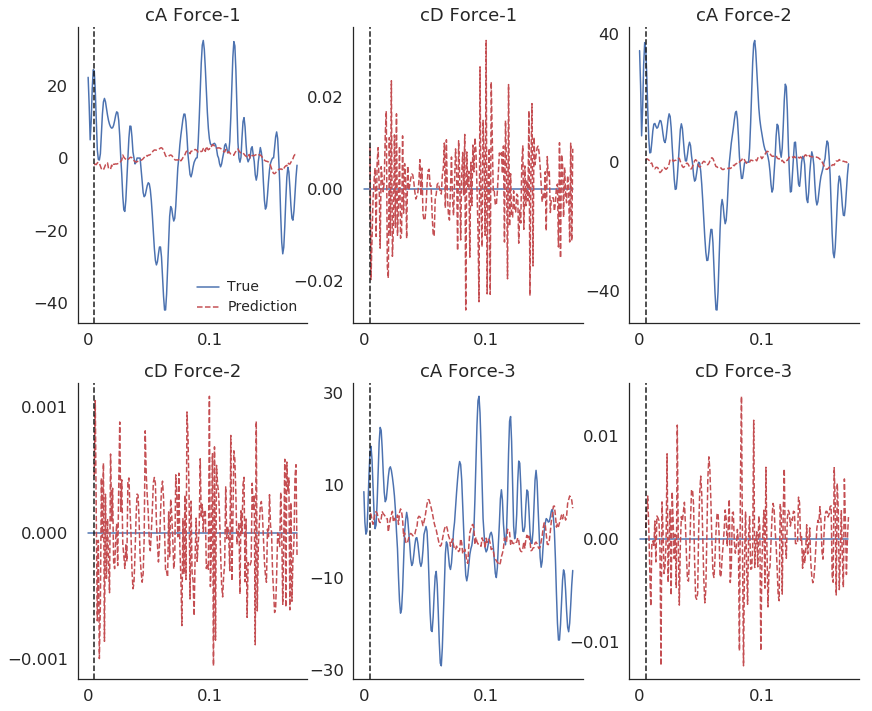

In [18]:
patient_id = 1
trial_id = 123
nPreds = 200 #number of samples to be predicted for each trial

# Plot the predictions in frequency domain given thresholded DWT coeffs for 
# different combinations of eeg+emg+force:

if modality in [0,2]: # eeg prediction
    P = 0
    sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
    # Set up the matplotlib figure (all forecasts subplot figure)
    f, axes = plt.subplots(5, 3, figsize=(14, 24), sharex=False, sharey=False)
    sns.despine()

    x_gt=np.arange(0, (nPreds+P)/fs, 1/fs)
    x_pred=np.arange(P/fs, (nPreds+P)/fs, 1/fs)

    T = math.floor(10*(nPreds+P)/fs) + 1

    if T != 1:
        z = [decimal.Decimal(i) / decimal.Decimal(10) for i in range(0, T)]
    else:
        T = math.floor(100*(nPreds+P)/fs) + 1
        z = [decimal.Decimal(i) / decimal.Decimal(100) for i in range(0, T, 2)]

    plt.setp(axes, xticks=z, xticklabels=z)

    for j in range(1,15,1):
        sns.set()
        axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_wavelet[patient_id][trial_id].iloc[:nPreds+P, 2*(j-1)].values, 
                                               color='b', label="True")
        axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, f_list[modality][patient_id][trial_id].iloc[:nPreds, 2*(j-1)].values, 
                                                color='r', linestyle='--', label="Prediction")
        axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
        axes[math.floor((j-1)/3), (j-1)%3].title.set_text("cA EEG-%i" %j)
        axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
        axes[0, 0].legend(frameon=False)
        plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

    plt.savefig("VARResults/predictions_waveletDomain_regression.pdf", bbox_inches="tight")
    
elif modality in [1,3]: # force prediction
    P = 6
    sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
    # Set up the matplotlib figure (all forecasts subplot figure)
    f, axes = plt.subplots(2, 3, figsize=(14, 12), sharex=False, sharey=False)
    sns.despine()

    x_gt=np.arange(0, (nPreds+P)/fs, 1/fs)
    x_pred=np.arange(P/fs, (nPreds+P)/fs, 1/fs)

    T = math.floor(10*(nPreds+P)/fs) + 1

    if T != 1:
        z = [decimal.Decimal(i) / decimal.Decimal(10) for i in range(0, T)]
    else:
        T = math.floor(100*(nPreds+P)/fs) + 1
        z = [decimal.Decimal(i) / decimal.Decimal(100) for i in range(0, T, 2)]

    plt.setp(axes, xticks=z, xticklabels=z)

    for j in range(1,7,1):
        sns.set()
        axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_wavelet[patient_id][trial_id].iloc[:nPreds+P, j-1].values, 
                                               color='b', label="True")
        axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, f_list[modality][patient_id][trial_id].iloc[:nPreds, j-1].values, 
                                                color='r', linestyle='--', label="Prediction")
        axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
        if j%2 == 1:
            axes[math.floor((j-1)/3), (j-1)%3].title.set_text("cA Force-%i" %int(ceil(j/2)))
        else:
            axes[math.floor((j-1)/3), (j-1)%3].title.set_text("cD Force-%i" %int(ceil(j/2)))
        axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
        axes[0, 0].legend(frameon=False)
        plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

    plt.savefig("VARResults/predictions_waveletDomain_regression.pdf", bbox_inches="tight")

### Visualizing Predictions of Test Data Over Time Domain

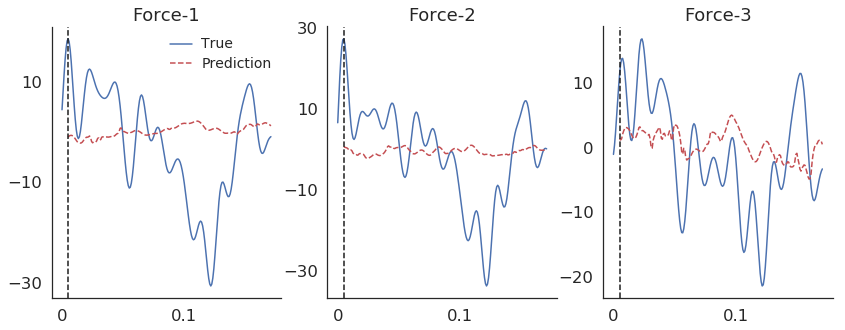

In [19]:
# Plot the predictions in time domain given thresholded DWT coeffs 
# for different combinations of eeg+emg+force:
modality=1
if modality in [0,2]: # eeg prediction
    P = 0
    x_gt=np.arange(0, (nPreds+P)/fs, 1/fs)
    x_pred=np.arange(P/fs, (nPreds+P)/fs, 1/fs)
    
    sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
    # Set up the matplotlib figure (all forecasts subplot figure)
    f, axes = plt.subplots(5, 3, figsize=(14, 24), sharex=False, sharey=False)
    sns.despine()

    plt.setp(axes, xticks=z, xticklabels=z)

    for j in range(1,15,1):
        sns.set()
        axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_data[patient_id][trial_id].iloc[:nPreds+P,j-1].values, 
                                               color='b', label="True")
        axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, 
                                                s_list[modality][patient_id][trial_id].iloc[:nPreds,j-1].values, 
                                                color='r', linestyle='--', label="Prediction")
        axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
        axes[math.floor((j-1)/3), (j-1)%3].title.set_text("EEG-%i" %j)
        axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
        axes[0, 0].legend(frameon=False)
        plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

    plt.savefig("VARResults/predictions_timeDomain_regression.pdf", bbox_inches="tight")

elif modality in [1,3]: # force prediction
    P = 6
    x_gt=np.arange(0, (nPreds+P)/fs, 1/fs)
    x_pred=np.arange(P/fs, (nPreds+P)/fs, 1/fs)
    
    sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
    # Set up the matplotlib figure (all forecasts subplot figure)
    f, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=False, sharey=False)
    sns.despine()

    plt.setp(axes, xticks=z, xticklabels=z)

    for j in range(1,4,1):
        sns.set()
        axes[(j-1)%3].plot(x_gt, test_data[patient_id][trial_id].iloc[:nPreds+P,j-1].values, 
                           color='b', label="True")
        axes[(j-1)%3].plot(x_pred, s_list[modality][patient_id][trial_id].iloc[:nPreds,j-1].values, 
                           color='r', linestyle='--', label="Prediction")
        axes[(j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
        axes[(j-1)%3].title.set_text("Force-%i" %j)
        axes[(j-1)%3].set_yticks(axes[(j-1)%3].get_yticks()[1:-1:2])
        axes[0].legend(frameon=False)
        plt.setp(axes[0].get_legend().get_texts(), fontsize='14')

    plt.savefig("VARResults/predictions_timeDomain_regression.pdf", bbox_inches="tight")

### Displaying Goodness of Fit Performance for Different Input Combinations